# Logreg, FCNN, CNN, BERT baselines

In [1]:
!pip install spacy textvec
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# Data
import pandas as pd
import numpy as np

# Preprocessing
import nltk
import re
import spacy

# ML
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from textvec.vectorizers import TforVectorizer

# NNs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

#Utils
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
# BERT Model
!pip install transformers
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig

     |████████████████████████████████| 778kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 28.6MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
     |████████████████████████████████| 3.0MB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c0d4ccbb138d02ecf4b1bcb8ae4748a9ec0e0d58ee32cce96e6ff5d3dd103a70
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Define datafolder
# If you are using google colab you can put data in /content/drive/My Drive/Colab/Real-or-Not/data/
try:
    from google.colab import drive
    is_in_colab = True
    
except:
    is_in_colab = False

if is_in_colab:
    drive.mount('/content/drive')
    data_folder = r'/content/drive/My Drive/Colab/Real-or-Not/data/'
else:
    # Kaggle kernel
    data_folder = r'../input/nlp-getting-started'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Look at data and task review

 We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0. Its binary classification task.

In [5]:
data = pd.read_csv(data_folder + '/train.csv')
data.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

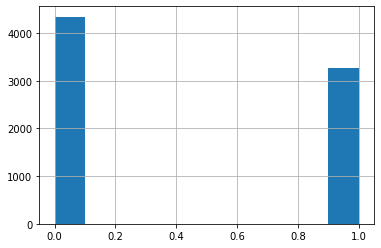

In [6]:
# Look at the class ratio
data.target.hist()
data.target.describe()

We have a good balanced dataset. But keep in mind that there are situations when the dataset can be unbalanced so we have to do oversampling or downsampling.

# Preprocessing functions

In [7]:
def clean(text):
  text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',    # Substitute different urls with "url" token.
                  'url', text)
  text = re.sub('#', '', text)              # Delete hashtag signs.
  text = re.sub('\d+[.,]?\d*', 'num', text)  # Substitute different numbers with "num" token.                                                 
  text = re.sub('@\w+_?\w*', 'username', text)  # Substitute different usernames with 'username' token.                                                       
  return text

def lemmatize(text):
  preprocessed_tokens = []    # preprocessed_tokens will be lemmatized, stopwords removed and lowercased
  nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])   # We will not use NER and syntactic parser.
  doc = nlp(text)
  for token in doc:
    if not token.is_stop:
      preprocessed_tokens.append(token.lemma_.lower())
  return ' '.join(preprocessed_tokens)

In [ ]:
data['text'] = data.text.apply(clean)    # Clean texts.
data['lemmatized_text'] = data.text.apply(lemmatize)  # Add new column with lemmatized and preprocessed texts. This task requires a lot of time.
data.drop(['keyword', 'location'], axis=1, inplace=True) # We don't need 'keyword', 'location' columns.

In [14]:
# data.to_pickle(data_folder+'/cleaned_lemmatized_train.pkl')
data = pd.read_pickle(data_folder + 'cleaned_lemmatized_train.pkl')
data.head(10)

,id,text,target,lemmatized_text
0,1,Our Deeds are the Reason of this earthquake Ma...,1,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask . canada
2,5,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place ' notify officer ...
3,6,num people receive wildfires evacuation orders...,1,num people receive wildfire evacuation order c...
4,7,Just got sent this photo from Ruby Alaska as s...,1,get send photo ruby alaska smoke wildfire pour...
5,8,RockyFire Update => California Hwy. num closed...,1,rockyfire update = > california hwy . num clos...
6,10,flood disaster Heavy rain causes flash floodin...,1,flood disaster heavy rain cause flash flooding...
7,13,I'm on top of the hill and I can see a fire in...,1,hill fire wood ...
8,14,There's an emergency evacuation happening now ...,1,emergency evacuation happen building street
9,15,I'm afraid that the tornado is coming to our a...,1,afraid tornado come area ...


## BOW features

In [15]:
# Split data on train and test.
X_train, X_val, y_train, y_val = train_test_split(data, data.target, train_size = 0.8, random_state=42)   

In [16]:
# We will use TF-IDF and TFOR as features describing texts.
# We will try word level features using lemmas and char level features. 

word_vectorizer = TfidfVectorizer(    # TF-IDF for word level features.
    analyzer='word',                  # Word level tokenization.
    ngram_range=(1, 1),               # We don't use ngrams. But you can try.
    max_features=10000,      # Number of max features (it will be shape of our training matrix: shape=(num_documents,max_features))
    max_df=0.7,                        # We will not use tokens that are found in more than 70 percent of documents
    min_df=1)                          # We will not use tokens that are found only in 1 document

char_vectorizer = TfidfVectorizer(    # TF-IDF for char level features.
    analyzer='char',                  # Char level tokenization.                            
    ngram_range=(1, 4),               # We use [1..4]grams. 
    max_features=30000,                                   
    max_df=0.7,                                            
    min_df=1
    )

# Get char ngrams features for the train set and the validation set.
word_vectorizer.fit(data.lemmatized_text)

train_w_features = word_vectorizer.fit_transform(X_train.lemmatized_text)
val_w_features = word_vectorizer.transform(X_val.lemmatized_text)

# Get lemma features for the train set and the validation set.
char_vectorizer.fit(data.text)

train_c_features = char_vectorizer.transform(X_train.text)
val_c_features = char_vectorizer.transform(X_val.text)

# We can use information about classes in features with help of supervised vectorizer. 
# For example, TFOR (for binary classification) from textvec lib. Let's fit TFOR on char ngrams.
tfor = TforVectorizer()

tfor_train = tfor.fit_transform(char_vectorizer.transform(X_train.text), y_train)
tfor_val = tfor.transform(char_vectorizer.transform(X_val.text))


# Classic models

## Logistic Regression

In [17]:
# Logreg on tf-idf char ngrams from cleaned texts

# You should try different values of C [0.01, 0.1, 1, 10], solver ['liblinear', 'sag'], penalty ['l1', 'l2']

logreg = LogisticRegression(C=1, solver='sag')             
logreg.fit(train_c_features, y_train)
preds = logreg.predict(val_c_features)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [18]:
# Logreg on tf-idf lowercased lemmas from cleaned, lemmatized, stop words filtered texts.

# You should try different values of C [0.01, 0.1, 1, 10], solver ['liblinear', 'sag'], penalty ['l1', 'l2']

logreg = LogisticRegression(C=1, solver='sag')               
logreg.fit(train_w_features, y_train)
preds = logreg.predict(val_w_features)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



**!!! It is possible if lemmatization doesn't work because stop words or special forms of words can be important features.**

In [19]:
# Logreg on tfor char ngrams from cleaned texts

# You should try different values of C [0.01, 0.1, 1, 10], solver ['liblinear', 'sag'], penalty ['l1', 'l2']

logreg = LogisticRegression(C=1, solver='sag')            
logreg.fit(tfor_train, y_train)
preds = logreg.predict(tfor_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.81      0.71      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



TFOR is a little better. But TFOR must give better balance between precision and recall.

# Neural Network

## Define functions for learning NNs.

In [20]:
# Resolve what Tensors we will use - GPU or CPU. 
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device('cuda:0')
    from torch.cuda import FloatTensor, LongTensor            # Import GPU Tensors.
else:
    device = torch.device('cpu')
    from torch import FloatTensor, LongTensor                 # Import CPU Tensors.

In [21]:
is_cuda

True

In [22]:
# This function for training NN models.

def fit(model, loss_function, train_data=None, val_data=None, optimizer=None,
        epoch_count=1, batch_size=1, scheduler=None, alpha=1, type_nn=None):
  
    train_history = []
    val_history = []

    for epoch in range(epoch_count):
            name_prefix = '[{} / {}] '.format(epoch + 1, epoch_count)
            epoch_train_score = 0
            epoch_val_score = 0
            
            if train_data:
                epoch_train_score = do_epoch(model, loss_function, train_data, batch_size, 
                                              optimizer, name_prefix + 'Train:', alpha=alpha, type_nn=type_nn,
                                             scheduler=scheduler)
                train_history.append(epoch_train_score)

            if val_data:
                name = '  Val:'
                if not train_data:
                    name = ' Test:'
                epoch_val_score = do_epoch(model, loss_function, val_data, batch_size, 
                                             optimizer=None, name=name_prefix + name, alpha=alpha, type_nn=type_nn,
                                           scheduler=scheduler)
                
                val_history.append(epoch_val_score)

    return train_history, val_history
    

In [23]:
# This is a function for generating one epoch for each NN model (BERT, FNN, CNN).

def do_epoch(model, loss_function, data, batch_size, optimizer=None, name=None, alpha=1, type_nn=None, scheduler=None):
    """
       One epoch generation
    """
    accuracy = 0
    epoch_loss = 0
   
    batch_count = len(data)
   
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batch_count) as progress_bar:               
            for ind, batch in enumerate(data):
                if type_nn == 'BERT':
                  X_batch, X_mask, y_batch =  batch[0].to(device), batch[1].to(device), batch[2].to(device)
                  loss, prediction = model(X_batch, token_type_ids=None, attention_mask=X_mask, labels=y_batch)
                if type_nn == 'CNN':
                  X_batch, y_batch = batch
                  prediction = model(X_batch)
                  loss = loss_function(prediction, y_batch)
                if type_nn == 'FNN':
                  X_batch, y_batch = batch[0].to(device), batch[1].to(device)
                  prediction = model(X_batch)
                  loss = loss_function(prediction, y_batch)

                  for param in model.children():
                    if type(param) == nn.Linear:
                        loss += alpha * torch.abs(param.weight).sum()

                epoch_loss += loss.item()

                true_indices = torch.argmax(prediction, dim=1)
                correct_samples = torch.sum(true_indices == y_batch).cpu().numpy()
                accuracy += correct_samples / y_batch.shape[0]

                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if scheduler: scheduler.step(accuracy)
              
                progress_bar.update()
                progress_bar.set_description('Epoch {} - accuracy: {:.2f}, loss {:.2f}'.format(
                    name, (accuracy / (ind+1)), epoch_loss / (ind+1))
                )
            
            accuracy /= (ind + 1)
            epoch_loss /= (ind + 1) 
            progress_bar.set_description(f'Epoch {name} - accuracy: {accuracy:.2f}, loss: {epoch_loss:.2f}')

    return accuracy

## BERT

In [24]:
# Preparing data
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [25]:
def prepare_data_for_bert(texts):
  MAX_LEN = 0
  input_ids = []
  attention_masks = []
  for tweet in texts:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_tweet = bert_tokenizer.encode(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
 
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_tweet)
 
    if len(encoded_tweet) > MAX_LEN:
      MAX_LEN = len(encoded_tweet)
 
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                        value=0, truncating="post", padding="post")
  
  # Make attention masks token -> 1, [PAD] -> 0
  for tweet in input_ids:
    att_mask = [int(token_id > 0) for token_id in tweet]
    attention_masks.append(att_mask)
    
  return input_ids, attention_masks

In [26]:
# Prepare data for BERT
input_ids, attention_masks = prepare_data_for_bert(data.text)
labels = data.target.values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.25)



In [27]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_masks), torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [28]:
# Load model
bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

bert.cuda()   #To GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# Number of training epochs (between 2 and 4 recommended)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# AdamW is a class from the huggingface library. Read docs for get an idea of parameters.
optimizer = AdamW(bert.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, you can try [1e-5 .. 5e-5]
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [30]:
train_history_bert, val_history_bert = fit(bert, loss_function=None, train_data=train_dataloader, val_data=validation_dataloader, optimizer=optimizer, epoch_count=epochs, batch_size=batch_size, type_nn='BERT', scheduler=scheduler, alpha=1, )

  0%|          | 0/357 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch [1 / 3] Train: - accuracy: 0.80, loss: 0.46: 100%|██████████| 357/357 [01:24<00:00,  4.23it/s]
Epoch [1 / 3]   Val: - accuracy: 0.83, loss: 0.41: 100%|██████████| 119/119 [00:09<00:00, 12.31it/s]
Epoch [2 / 3] Train: - accuracy: 0.87, loss: 0.32: 100%|██████████| 357/357 [01:29<00:00,  4.00it/s]
Epoch [2 / 3]   Val: - accuracy: 0.83, loss: 0.44: 100%|██████████| 119/119 [00:09<00:00, 12.32it/s]
Epoch [3 

## LinearNN

In [33]:
# Prepare data for NN

# Create the DataLoader for our training set. We will use TF-IDF matrix
train_data = TensorDataset(torch.FloatTensor(train_c_features.toarray()), torch.tensor(np.array(y_train)))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.  We will use TF-IDF matrix
validation_data = TensorDataset(torch.FloatTensor(val_c_features.toarray()), torch.tensor(np.array(y_val)))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [34]:
# fit settings
batch_size = 100
epoch_count = 4

# optim settings. You should try different values.
learning_rate = 1e-4
weight_decay = 0.1
alpha = 0.005

# model settings. 
linear1_out = int(val_c_features.shape[1]**0.5)            # You should try different values.
output = 2                                                 # Equals to num classes.
dropout = 0.3                                              # You should try different values.


model = nn.Sequential(nn.Linear(train_c_features.shape[1], linear1_out),
                      nn.BatchNorm1d(linear1_out),
#                       nn.Dropout(p=dropout, inplace=True),
                      nn.ReLU(inplace=True),
                      nn.Linear(linear1_out, output),
                      nn.ReLU(inplace=True)
                     ).to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(
                        model.parameters(),
                        lr=learning_rate, 
                        weight_decay=weight_decay
                    )

#

In [35]:
train_history, val_history = fit(model, loss_function, train_dataloader, validation_dataloader, optimizer, epoch_count, batch_size, scheduler=None, alpha=alpha, type_nn='FNN')

Epoch [1 / 4] Train: - accuracy: 0.71, loss: 27.24: 100%|██████████| 61/61 [00:00<00:00, 83.32it/s]
Epoch [1 / 4]   Val: - accuracy: 0.67, loss: 3.04: 100%|██████████| 16/16 [00:00<00:00, 121.65it/s]
Epoch [2 / 4] Train: - accuracy: 0.76, loss: 1.59: 100%|██████████| 61/61 [00:00<00:00, 92.34it/s]
Epoch [2 / 4]   Val: - accuracy: 0.77, loss: 1.24: 100%|██████████| 16/16 [00:00<00:00, 121.52it/s]
Epoch [3 / 4] Train: - accuracy: 0.76, loss: 1.20: 100%|██████████| 61/61 [00:00<00:00, 96.27it/s]
Epoch [3 / 4]   Val: - accuracy: 0.76, loss: 1.19: 100%|██████████| 16/16 [00:00<00:00, 126.67it/s]
Epoch [4 / 4] Train: - accuracy: 0.77, loss: 1.18: 100%|██████████| 61/61 [00:00<00:00, 94.22it/s]
Epoch [4 / 4]   Val: - accuracy: 0.78, loss: 1.16: 100%|██████████| 16/16 [00:00<00:00, 107.68it/s]


# CNN

In [36]:
# Prepare data for torch dataset in Google colab or local
train, val = train_test_split(data[['text', 'target']], train_size = 0.8, random_state=42)
train.to_csv(data_folder + 'train_cnn.csv')
val.to_csv(data_folder + 'val_cnn.csv')

#In Kaggle Kernel I uploaded splitted train data
#cnn_data = '../input/realornottrainsplitted/'

In [38]:
# Prepare torch dataset

import torchtext

MAX_TEXT_LEN = max(data.text.apply(lambda x: len(x)))

train, val = train_test_split(data[['text', 'target']], train_size = 0.8, random_state=42)

text_field = torchtext.data.Field(lower=True, include_lengths=False, fix_length=1000, batch_first=True)
target_field = torchtext.data.Field(sequential=False, is_target=True, use_vocab=False)

train_dataset = torchtext.data.TabularDataset(data_folder + 'train_cnn.csv', format='csv', fields={'text': ('text', text_field), 'target': ('target', target_field)})
val_dataset = torchtext.data.TabularDataset(data_folder + 'val_cnn.csv', format='csv', fields={'text': ('text', text_field), 'target': ('target', target_field)})

text_field.build_vocab(train_dataset, min_freq=2)
target_field.build_vocab(train_dataset)
vocab = text_field.vocab


print('Vocab size: ', len(vocab))
print(train_dataset[0].text)
print(train_dataset[0].target)

Vocab size:  5927
['courageous', 'and', 'honest', 'analysis', 'of', 'need', 'to', 'use', 'atomic', 'bomb', 'in', 'num', 'hiroshimanum', 'japanese', 'military', 'refused', 'surrender.', 'url']
1


In [39]:
# Define architecture of our CNN.

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, n_classes,
                 kernel_sizes_cnn, filters_cnn: int, dense_size: int,
                 dropout_rate: float = 0.,):
        super().__init__()

        self._n_classes = n_classes
        self._vocab_size = vocab_size
        self._embedding_size = embedding_size
        self._kernel_sizes_cnn = kernel_sizes_cnn
        self._filters_cnn = filters_cnn
        self._dense_size = dense_size
        self._dropout_rate = dropout_rate

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)

        self.cnns = []
        for i in range(len(kernel_sizes_cnn)):
            in_channels = embedding_size

            cnn = nn.Sequential(
                nn.Conv1d(in_channels, filters_cnn, kernel_sizes_cnn[i]),
                nn.BatchNorm1d(filters_cnn),
                nn.ReLU()
            )
            cnn.apply(self.init_weights)

            self.add_module(f'cnn_{i}', cnn)
            self.cnns.append(cnn)
        
        # concatenated to hidden to classes
        self.projection = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(filters_cnn * len(kernel_sizes_cnn), dense_size),
            nn.BatchNorm1d(dense_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dense_size, n_classes)
        )

    @staticmethod
    def init_weights(module):
        if type(module) == nn.Linear or type(module) == nn.Conv1d:
            nn.init.kaiming_normal_(module.weight)

    def forward(self, x):
        x0 = self.embedding(x)
        x0 = torch.transpose(x0, 1, 2)

        outputs0 = []
        outputs1 = []

        for i in range(len(self.cnns)):
            cnn = getattr(self, f'cnn_{i}')
            # apply cnn and global max pooling
            pooled, _ = cnn(x0).max(dim=2)
            outputs0.append(pooled)

        x0 = torch.cat(outputs0, dim=1) if len(outputs0) > 1 else outputs0[0]
        return self.projection(x0)

In [40]:
# Prepare data loaders.
train_loader, val_loader = torchtext.data.Iterator.splits((train_dataset, val_dataset),
                                                           batch_sizes=(64, 64),
                                                           sort=False,
                                                           device='cuda')

batch = next(iter(train_loader))
print(batch)


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.cuda.LongTensor of size 64x1000 (GPU 0)]
	[.target]:[torch.cuda.LongTensor of size 64 (GPU 0)]


In [41]:
# Init CNN model and parameters.

epochs = 8                        # you can different number of epochs. 
batch_size = 32                   # you can different number of batch size. 

vocab_size = len(vocab)
embedding_size = 300
n_classes = 2
kernel_sizes = (1, 2, 3, 5)       # You can try different values.
dense_size = 256                  # You can try different values.
dropout = 0.5                     # You can try different values.
filters_size = 512                # You can try different values.

model = CNN(vocab_size, embedding_size, n_classes, kernel_sizes,
            filters_size, dense_size, dropout)

model.cuda()  # move model to GPU

loss_function = nn.CrossEntropyLoss()
total_steps = len(train_loader) * epochs

# AdamW is a class from the huggingface library

# You can try different values of learning rate, i.e. [1e-2, 1e-3, 1e-4, 5e-3, 5e-4] and others. Check learning process to get the best value.

optimizer = AdamW(model.parameters(), 
                  lr=1e-3)                                          

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10,  # You can try different values.
                                            num_training_steps = total_steps)

In [42]:
train_history, val_history = fit(model, loss_function, train_loader, val_loader, optimizer, epochs, batch_size, scheduler, type_nn='CNN')

  0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch [1 / 8] Train: - accuracy: 0.63, loss: 0.67: 100%|██████████| 96/96 [00:22<00:00,  4.23it/s]
Epoch [1 / 8]   Val: - accuracy: 0.74, loss: 0.55: 100%|██████████| 24/24 [00:02<00:00, 11.54it/s]
Epoch [2 / 8] Train: - accuracy: 0.73, loss: 0.54: 100%|██████████| 96/96 [00:23<00:00,  4.13it/s]
Epoch [2 / 8]   Val: - accuracy: 0.76, loss: 0.52: 100%|██████████| 24/24 [00:02<00:00, 11.70it/s]
Epoch [3 / 8] Trai

# Resume

Our best model is BERT with accuracy score = 0.83. But we have a lightweight and fast model with accuracy score = 0.81 it the Logistic regression on TF-IDF char level features. Choosing the best model depends on your task and data that you have to be smart and experiment.
